---

### Описание проекта
<em> Я работаю в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

#### Цель исследования
<em> Изучение воронки событий пользователей мобильного приложения.

#### Ход исследования
1. <em> Выполнить обзор и предобработку данных;
2. <em> Изучить и проверить данные;
3. <em> Анализ воронки событий;
4. <em> Анализ результатов эксперимента;
5. <em> Выводы.

### Обзор и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import math as mth
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from plotly import graph_objects as go

In [50]:
try:
    df = pd.read_csv('logs_exp.csv',  delimiter='\t')
except:
    print('FileNotFoundError')

In [51]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
EventName,0.000000
DeviceIDHash,0.000000
EventTimestamp,0.000000
ExpId,0.000000


In [5]:
df.duplicated().sum()

413

In [6]:
df = df.rename( columns = { "EventName" : "event_name", "DeviceIDHash" : "user_id", "EventTimestamp":"event_timestamp", 
                      "ExpId": "exp_id" } )

In [7]:
df.head()

,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [8]:
df = df.drop_duplicates().reset_index(drop=True)

In [9]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s')
df['date'] = df['event_timestamp'].dt.date

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   date             243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


<strong> Мы выполнили предобработку данных: <strong>
1. <em> Столбцы приведены к нижнему регистру, были выбраны более удобные названия;
2. <em> Добавлены столбцы даты и времени и столбец дат;
3. <em> Пропусков нет, дубликаты удалены.

### Изучение и проверка данных

In [11]:
print('Общее число событий в логе:',len(df))

Общее число событий в логе: 243713


In [12]:
print('Общее число пользователей в логе:', df['user_id'].nunique())

Общее число пользователей в логе: 7551


In [13]:
print('В среднем событий приходится на пользователя:', round(len(df) / df['user_id'].nunique(),2))

В среднем событий приходится на пользователя: 32.28


In [14]:
min_date = df['event_timestamp'].min()
max_date = df['event_timestamp'].max()
print('Дата начала:', min_date)
print('Дата окончания:', max_date)

Дата начала: 2019-07-25 04:43:36
Дата окончания: 2019-08-07 21:15:17


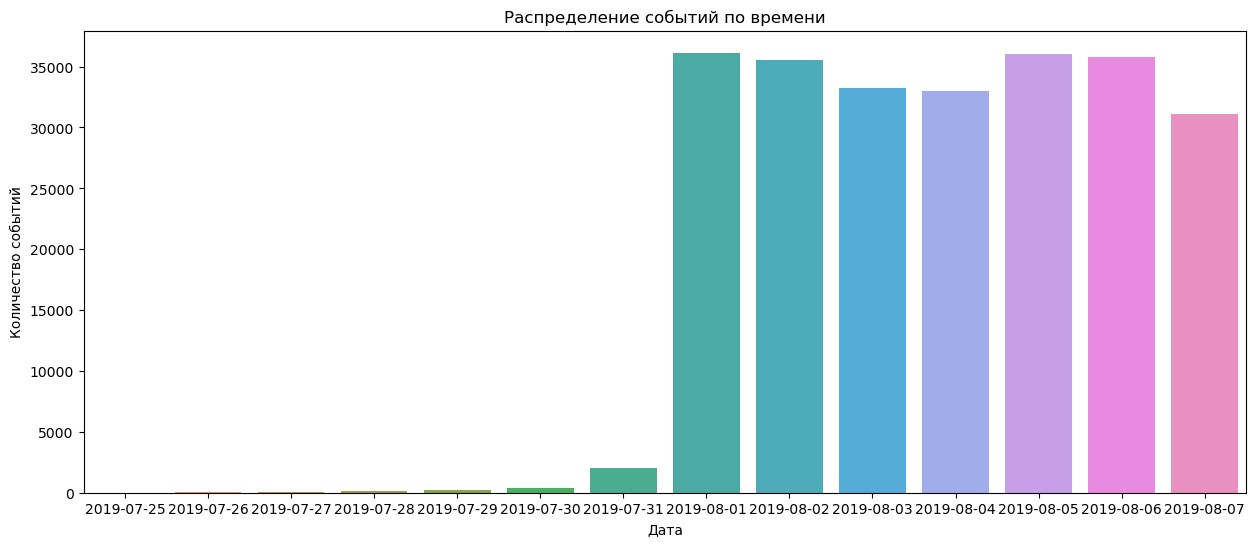

In [15]:
series = df.groupby('date')[['event_timestamp']].count().reset_index()
plt.figure(figsize=(15, 6))
ax = sns.barplot(x='date', y='event_timestamp', data=series)
plt.title('Распределение событий по времени')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

In [16]:
df['date'] = df['date'].astype('datetime64[D]')
df_new = df.query('date > "2019-07-31"')

In [17]:
print('Потеряли событий %d, это составляет около %d процента.' % ((len(df) - len(df_new)), 
                                                            round((len(df) - len(df_new)) / len(df) * 100, 2)) ) 

Потеряли событий 2826, это составляет около 1 процента.


In [18]:
print('Потеряли пользоватей %d, это составляет менее %d процента.' % ((df['user_id'].nunique() - df_new['user_id'].nunique()),  
mth.ceil((df['user_id'].nunique() - df_new['user_id'].nunique()) / df['user_id'].nunique() * 100)) ) 

Потеряли пользоватей 17, это составляет менее 1 процента.


In [19]:
df_new.groupby('exp_id').agg({'user_id': 'nunique'})

,user_id
exp_id,
246,2484
247,2513
248,2537


<em> Пользователи из всех трёх экспериментальных групп.

<em> Построив гистограмму мы получили информация что данные до 1 августа практически отсутствуют. Будем использовать данные с 1 августа, при очистке данных потеряно примерно 1% событий и менее 1% пользователей.

### Анализ воронки событий

In [20]:
df_new.groupby('event_name')['user_id'].count().reset_index().sort_values(by='user_id', ascending=False)

,event_name,user_id
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [21]:
event_users = df_new.groupby('event_name').agg({'user_id':'nunique'}).reset_index()
event_users.set_axis(['event_name', 'users_count'], axis='columns', inplace=True)
event_users['percent'] = event_users.users_count / df_new['user_id'].nunique()
event_users = event_users.sort_values('users_count', ascending=False).reset_index(drop=True)
event_users['funnel'] = 100
for i in range(1, 4):
    event_users.loc[i, 'funnel'] = event_users.loc[i, 'users_count'] /  (event_users.loc[i-1, 'users_count']) * 100
event_users

,event_name,users_count,percent,funnel
0,MainScreenAppear,7419,0.984736,100.000000
1,OffersScreenAppear,4593,0.609636,61.908613
2,CartScreenAppear,3734,0.495620,81.297627
3,PaymentScreenSuccessful,3539,0.469737,94.777718
4,Tutorial,840,0.111495,100.000000


<strong> Мы имеем 5 событий: <strong>
1. <em> MainScreenAppear - просмотр главной страницы;
2. <em> OffersScreenAppear - просмотр страницы предложений;
3. <em> CartScreenAppear - просмотр корзины;
4. <em> PaymentScreenSuccessful - переход на страницу успешной оплаты;
5. <em> Tutorial - обучение для новичков.

<em> Первые четыре события образуют цепочку движения пользователя по приложению. Туториал необязателен к прохождению.

<em> Общий процент перешедших на следующий уровень действий от главного экрана к экрану предложений 61.9%, перешедших от экрана предложения к экрану корзины 81.3%, от экрана корзины к экрану успешного платежа 94.8%.

In [22]:
event_users = event_users[event_users['event_name'] != 'Tutorial']
event_users

,event_name,users_count,percent,funnel
0,MainScreenAppear,7419,0.984736,100.000000
1,OffersScreenAppear,4593,0.609636,61.908613
2,CartScreenAppear,3734,0.495620,81.297627
3,PaymentScreenSuccessful,3539,0.469737,94.777718


<em> Уберём событие Туториал, так как оно является необязательным и для событий этого типа мала относительно других.

In [49]:
fig = go.Figure(go.Funnel(
    y = event_users['event_name'],
    x = event_users['percent'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["magenta", "lightpink", "khaki", "gold"] }) ,
               layout=go.Layout( title=go.layout.Title(text="Воронка приложения")))

fig.show()

<em> Большая часть пользователей теряется при переходе с гланого экрана на страницу предложений. До оплаты доходят примерно 48% пользователей.

### Анализ результатов эксперимента

In [25]:
groups = df_new.groupby('exp_id')['user_id'].nunique().reset_index()
groups

,exp_id,user_id
0,246,2484
1,247,2513
2,248,2537


<em> В первой группе 2484, во второй 2513, в третей 2537 пользователей. Группы 246 и 247 являются контрольными, группа 248 экспериментальная с изменённым шрифтом.

<strong> Критерии успешного A/A теста: <strong>

1. <em> Количество пользователей в различных группах различается не более, чем на 1%;
2. <em> Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
3. <em> Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
4. <em> Попавший в одну из групп посетитель остаётся в этой группе до конца теста.

In [26]:
groups_246 = int(groups[groups['exp_id'] == 246]['user_id'])
groups_247 = int(groups[groups['exp_id'] == 247]['user_id'])
print('Количество пользователей в группах различается на', round(100 - (groups_246 / groups_247 * 100), 2), '%')

Количество пользователей в группах различается на 1.15 %


<em> Количество пользователей в каждой из групп достаточно большое для проведения исследования и разница между размерами групп незначительная.

In [27]:
df_new.groupby('user_id')['exp_id'].nunique().reset_index().query('exp_id > 1').count()

user_id    0
exp_id     0
dtype: int64

<em> Среди пользователей нет попавших в несколько групп.

In [28]:
all_funnels = df_new.pivot_table(index='event_name', columns='exp_id',values='user_id',aggfunc='nunique').sort_values(246,ascending=False)
all_funnels['246+247'] = all_funnels[246] + all_funnels[247]
all_funnels.drop(['Tutorial'], inplace=True)
all_funnels

exp_id,246,247,248,246+247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


<em> Добавим общую группу пользователей объединяющую контрольные группы.

In [29]:
groups.loc[3] = ['246+247', 4997]
groups = groups.set_index(groups.columns[0])
groups

,user_id
exp_id,
246,2484
247,2513
248,2537
246+247,4997


<strong> Cформируем гипотезы: <strong>
1. <em> H0: Доля пользователей между группами, совершивших событие не отчичается;
2. <em> H1: Доля пользователей между группами, совершивших событе отличается.

<em> Для проверки гипотез воспользуемся Z-критерием и применим метод Бонферрони, так как проводим множественное сравнение.

In [30]:
def z_test_with_bonferroni_validation_result(group1, group2, event, alpha): 
    p1_event = all_funnels.loc[event, group1]
    p2_event = all_funnels.loc[event, group2] 
    p1_users = groups.loc[group1, 'user_id'] 
    p2_users = groups.loc[group2, 'user_id'] 
    p1 = p1_event / p1_users 
    p2 = p2_event / p2_users 
    difference = p1 - p2
    p_combined = (p1_event + p2_event) / (p1_users + p2_users) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_users + 1 / p2_users))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    bonferroni_alpha = alpha / 16
    
    print('Проверка для групп {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(group1, group2, event, p_value=p_value))
    if (p_value < bonferroni_alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

#### А/А тест

In [31]:
for event in all_funnels.index:
    z_test_with_bonferroni_validation_result(246, 247, event, 0.05)
    print()

Проверка для групп 246 и 247, событие: MainScreenAppear, p-значение: 0.76
Не получилось отвергнуть нулевую гипотезу

Проверка для групп 246 и 247, событие: OffersScreenAppear, p-значение: 0.25
Не получилось отвергнуть нулевую гипотезу

Проверка для групп 246 и 247, событие: CartScreenAppear, p-значение: 0.23
Не получилось отвергнуть нулевую гипотезу

Проверка для групп 246 и 247, событие: PaymentScreenSuccessful, p-значение: 0.11
Не получилось отвергнуть нулевую гипотезу



<em> Вывод о различии долей сделать нельзя. Результат А/А теста показывает, что обе контрольные группы показывают идентичные результаты. Это поможет сделать более достоверные выводы о дальнейшем A/B тестировании.

#### А/В тест

In [32]:
for event in all_funnels.index:
    z_test_with_bonferroni_validation_result(246, 248, event, 0.05)
    print()

Проверка для групп 246 и 248, событие: MainScreenAppear, p-значение: 0.29
Не получилось отвергнуть нулевую гипотезу

Проверка для групп 246 и 248, событие: OffersScreenAppear, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу

Проверка для групп 246 и 248, событие: CartScreenAppear, p-значение: 0.08
Не получилось отвергнуть нулевую гипотезу

Проверка для групп 246 и 248, событие: PaymentScreenSuccessful, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу



In [33]:
for event in all_funnels.index:
    z_test_with_bonferroni_validation_result(247, 248, event, 0.05)
    print()

Проверка для групп 247 и 248, событие: MainScreenAppear, p-значение: 0.46
Не получилось отвергнуть нулевую гипотезу

Проверка для групп 247 и 248, событие: OffersScreenAppear, p-значение: 0.92
Не получилось отвергнуть нулевую гипотезу

Проверка для групп 247 и 248, событие: CartScreenAppear, p-значение: 0.58
Не получилось отвергнуть нулевую гипотезу

Проверка для групп 247 и 248, событие: PaymentScreenSuccessful, p-значение: 0.74
Не получилось отвергнуть нулевую гипотезу



In [34]:
for event in all_funnels.index:
    z_test_with_bonferroni_validation_result('246+247', 248, event, 0.05)
    print()

Проверка для групп 246+247 и 248, событие: MainScreenAppear, p-значение: 0.29
Не получилось отвергнуть нулевую гипотезу

Проверка для групп 246+247 и 248, событие: OffersScreenAppear, p-значение: 0.43
Не получилось отвергнуть нулевую гипотезу

Проверка для групп 246+247 и 248, событие: CartScreenAppear, p-значение: 0.18
Не получилось отвергнуть нулевую гипотезу

Проверка для групп 246+247 и 248, событие: PaymentScreenSuccessful, p-значение: 0.60
Не получилось отвергнуть нулевую гипотезу



<em> Вывод о различии долей сделать нельзя. Изменение шрифта никак не повлияло на пользователей.

<em> Критический уровень статистической значимости alpha = 0.05, однако мы применили поправку Бонферрони, так как имеем дело с множественным сравнением.

<em> Провели 4 А/А-теста и 12 А/В-тестов.

### Выводы

1. <em> Наиболее часто встречающееся событие- 'MainScreenAppear' - 'Главный экран;
2. <em> События происходят в следующей цеполчке:
'MainScreenAppear' - 'OffersScreenAppear' - 'CartScreenAppear'-'PaymentScreenSuccessful'
3. <em> Событие Tutorial большинство пользователелей пропускает;
4. <em> От первого события до последнего доходит 47% пользователей;
5. <em> Количество пользователей между группами отличается на 1.15%;
6. <em> По результатам А/А/В-теста не было выявлено различий между контрольными и эксперементальной группами, можем сделать вывод, что изменение шрифта никак не повлияло на поведение пользователей.


---